In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from envelopy import envelopy as enpy
from pkg import pkg
from pkg import save

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

coordenadas = "-48.534679,-22.508117,-48.50481,-22.538879"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2018-01-01,2020-12-31"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])


sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    
v_emit_asc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
v_emit_desc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

image = ee.Image(dummy_value).blend(v_emit_desc.map(pkg.add_amplitude).select('amplitude').toBands())
image_names = image.bandNames().getInfo()

df = pkg.ee_to_pandas(image, geom, image_names, scale=10)

In [3]:
latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

my_map = geemap.Map(center=(longitude_central, latitude_central), zoom=13)
my_map.addLayer(geom)

rgb = ee.Image.rgb(
    v_emit_desc.mean().select('VV'),
    v_emit_desc.mean().select('VH'),
    v_emit_desc.mean().select('VV').divide(v_emit_desc.mean().select('VH'))
).clip(geom)

my_map.addLayer(rgb, {'min': [-25,-25,0], 'max': [0,0,2]})

my_map

Map(center=[-22.523498, -48.5197445], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=H…

In [4]:
renamed = pkg.rename_geodf(df)
reordered = renamed.reindex(sorted(renamed.columns), axis=1) 

In [5]:
def scale_all(df):
    names = df.columns
    mat = df.to_numpy()
    scaled_mat = (mat - np.mean(mat)) / np.std(mat)
    return pd.DataFrame(scaled_mat, columns=names)

coords = reordered.loc[:, ['latitude','longitude']]

scaled = scale_all(reordered.drop(['latitude','longitude'], axis=1)).join(coords)

In [85]:
test = scaled\
    .drop(['latitude','longitude'], axis=1)\
    .iloc[800,:]\
    .values\
    .reshape((-1,1))

In [86]:
xdata = np.concatenate((test, abs(test)**5), axis=1)
xdata

array([[-4.71128267e-01,  2.32111046e-02],
       [ 6.78128860e-02,  1.43403958e-06],
       [-9.39716202e-01,  7.32796818e-01],
       [-6.14966336e-01,  8.79542263e-02],
       [-1.20206543e-01,  2.50980821e-05],
       [-4.61761771e-01,  2.09937430e-02],
       [-7.40209110e-01,  2.22214364e-01],
       [-5.02516095e-01,  3.20442331e-02],
       [-2.93467193e-01,  2.17669604e-03],
       [ 2.64965564e-01,  1.30601201e-03],
       [-5.33952676e-01,  4.34024090e-02],
       [-3.08533404e-01,  2.79583123e-03],
       [ 6.07785086e-01,  8.29373578e-02],
       [ 4.30596851e-02,  1.48031536e-07],
       [-3.11787060e-01,  2.94639140e-03],
       [ 1.94258579e-01,  2.76631123e-04],
       [ 1.94551643e-01,  2.78724092e-04],
       [ 1.68529613e-01,  1.35950597e-04],
       [-3.69805284e-01,  6.91616842e-03],
       [-2.82703341e-01,  1.80573787e-03],
       [-3.88298055e-01,  8.82726320e-03],
       [ 1.96759032e-01,  2.94899062e-04],
       [ 3.04998518e-01,  2.63929931e-03],
       [-6.

In [87]:
envelope = enpy.specenv(xdata)
envelope

array([[ 1.04166667e-02,  9.56839824e-05, -8.10451061e-01,
         5.85806348e-01],
       [ 2.08333333e-02,  1.76315997e-02,  3.25742403e-01,
        -9.45458559e-01],
       [ 3.12500000e-02,  5.26456332e-02, -5.60051254e-01,
        -8.28457961e-01],
       [ 4.16666667e-02,  3.26908834e-04, -2.82684050e-01,
         9.59213077e-01],
       [ 5.20833333e-02,  6.89043029e-02,  7.26258272e-01,
        -6.87421939e-01],
       [ 6.25000000e-02,  2.83561652e-02,  4.48152302e-01,
        -8.93957222e-01],
       [ 7.29166667e-02,  6.91248327e-02,  4.49602495e-01,
         8.93228748e-01],
       [ 8.33333333e-02,  1.72502828e-02, -8.77490704e-01,
         4.79593646e-01],
       [ 9.37500000e-02,  9.09186193e-02,  9.94891830e-01,
        -1.00946747e-01],
       [ 1.04166667e-01,  1.98634082e-02,  8.98081831e-01,
        -4.39828405e-01],
       [ 1.14583333e-01,  8.69724107e-03,  4.00393798e-01,
        -9.16343171e-01],
       [ 1.25000000e-01,  1.00352102e-01,  9.33500532e-01,
      

In [88]:
b = envelope[envelope[:,1]==max(envelope[:,1]), 2:]
opt = np.sum(xdata*b, axis=1)

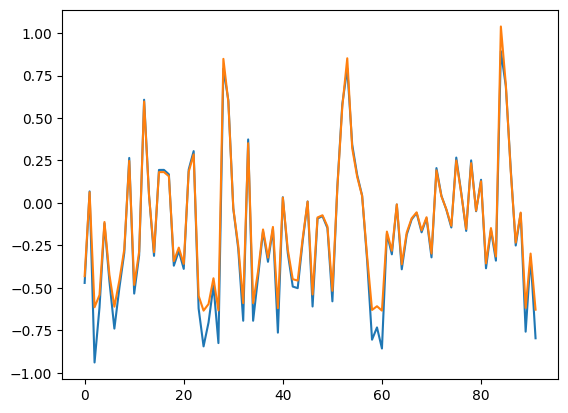

In [89]:
plt.clf()
plt.plot(test)
plt.plot(opt)
plt.show()